In [1]:
import jax
import optax
import jax.numpy as jnp
from typing import NamedTuple

### `zip`

In [2]:
# ts : transform, i: init, u: update

ts1 = ("i1", "u1")
ts2 = ("i2", "u2")
ts3 = ("i3", "u3")
ts4 = ("i4", "u4")
ts5 = ("i5", "u5")

ts_list = [ts1, ts2, ts3, ts4, ts5]

i_list, u_list = zip(*ts_list)

print(i_list)
print(u_list)

('i1', 'i2', 'i3', 'i4', 'i5')
('u1', 'u2', 'u3', 'u4', 'u5')


### `NameTuple`

In [3]:
class test(NamedTuple):
    a: int
    b: int

In [4]:
test(1, 2)

test(a=1, b=2)

### `Typing` in `optax`

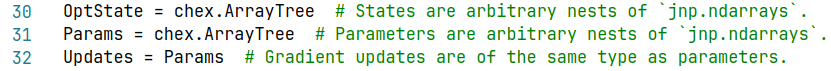

### `closure`

추천 자료 : [Python의 Closure에 대해 알아보자](https://shoark7.github.io/programming/python/closure-in-python)

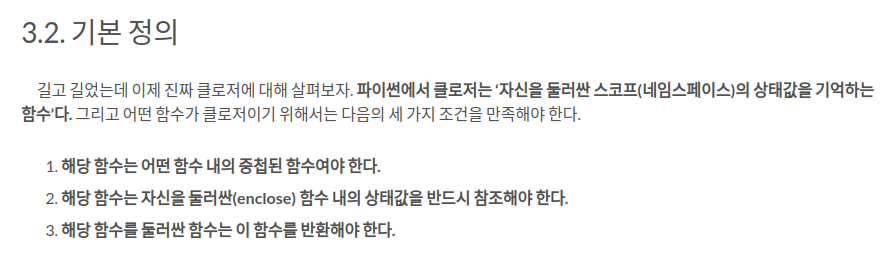

In [5]:
def in_cache(func):
    cache = {}
    def wrapper(n):
        print(cache) ## !!!!
        if n in cache:
            return cache[n]
        else:
            cache[n] = func(n)
            return cache[n]
    return wrapper


def factorial(n):
    ret = 1
    for i in range(1, n+1):
        ret *= i
    return ret

factorial = in_cache(factorial)

In [6]:
factorial(3)
factorial(5)
factorial(10)

{}
{3: 6}
{3: 6, 5: 120}


3628800

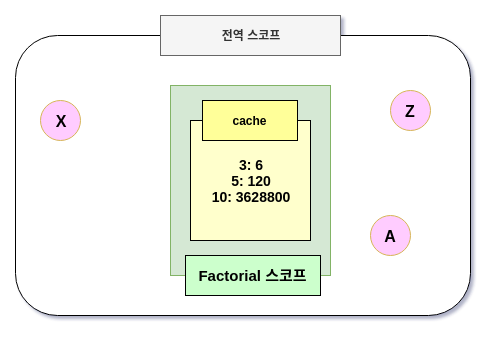

closure 함수 입장에서 참조하는 값을 바꾸면서 하는 연산이라면 해당 함수 입장에서 pure function이 아니기 때문에 `jit` 하면 그 값은 업데이트 되지 않겠지만 참조해야 하는 것이 바뀌지 않을 경우에는 괜찮다. 그것은 꼭 변수일 필요없이 **함수**여도 된다.

---

In [7]:
learning_rate = 0.0003
param = jnp.array([[1., 2., 3.]])
tx = optax.adam(learning_rate)

### `alias.py` > function `adam`

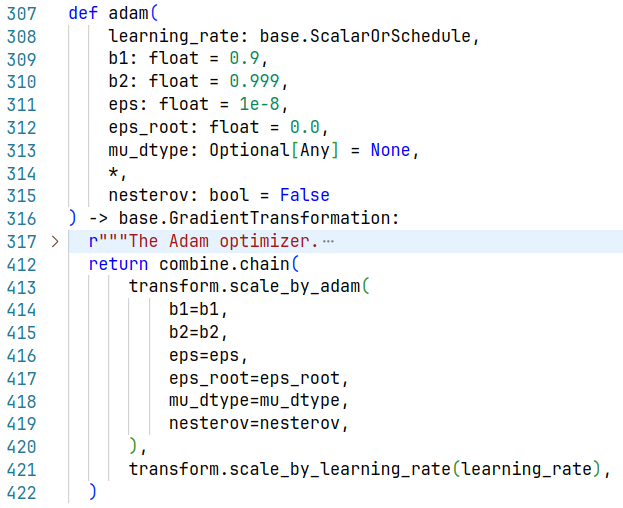

모든 `optimizer` 함수에는 `scale_by_learning_rate`가 포함된다.

### `transform.py` > fun `scale_by_adam`

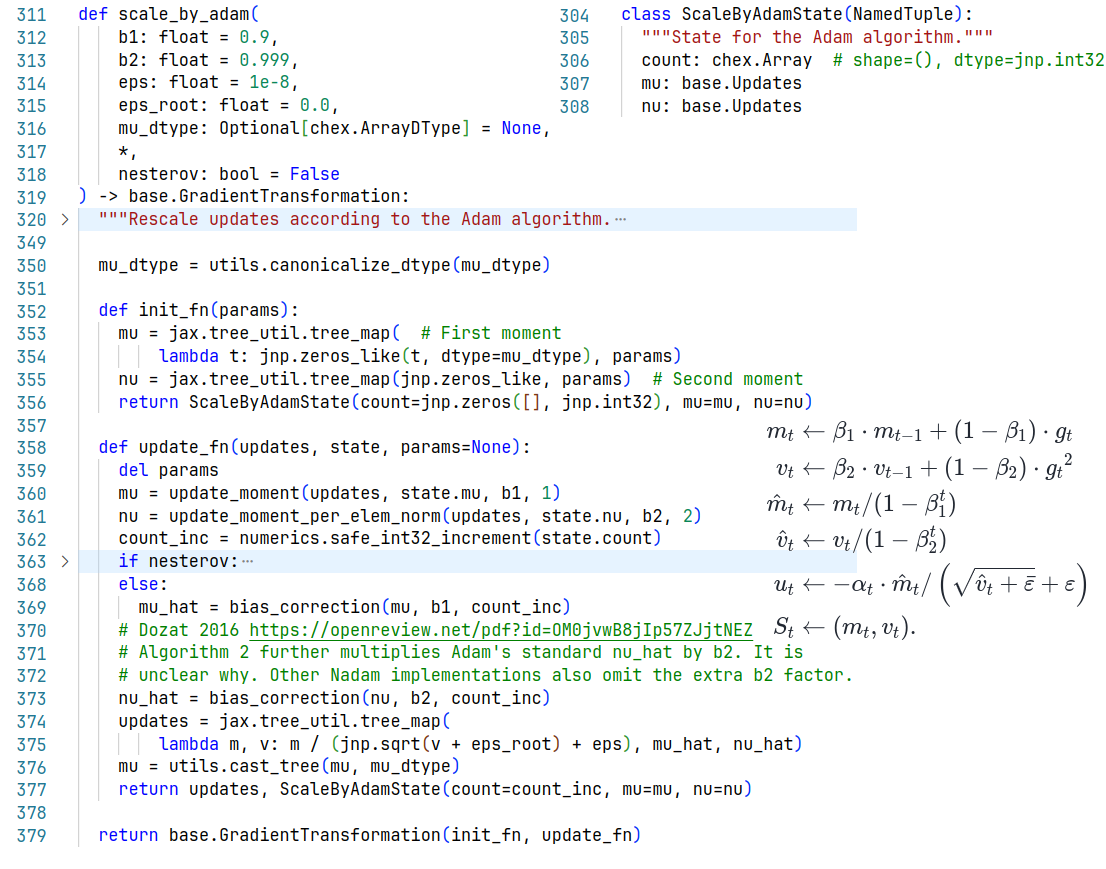

### `transform.py` > `scale_by_learning_rate`

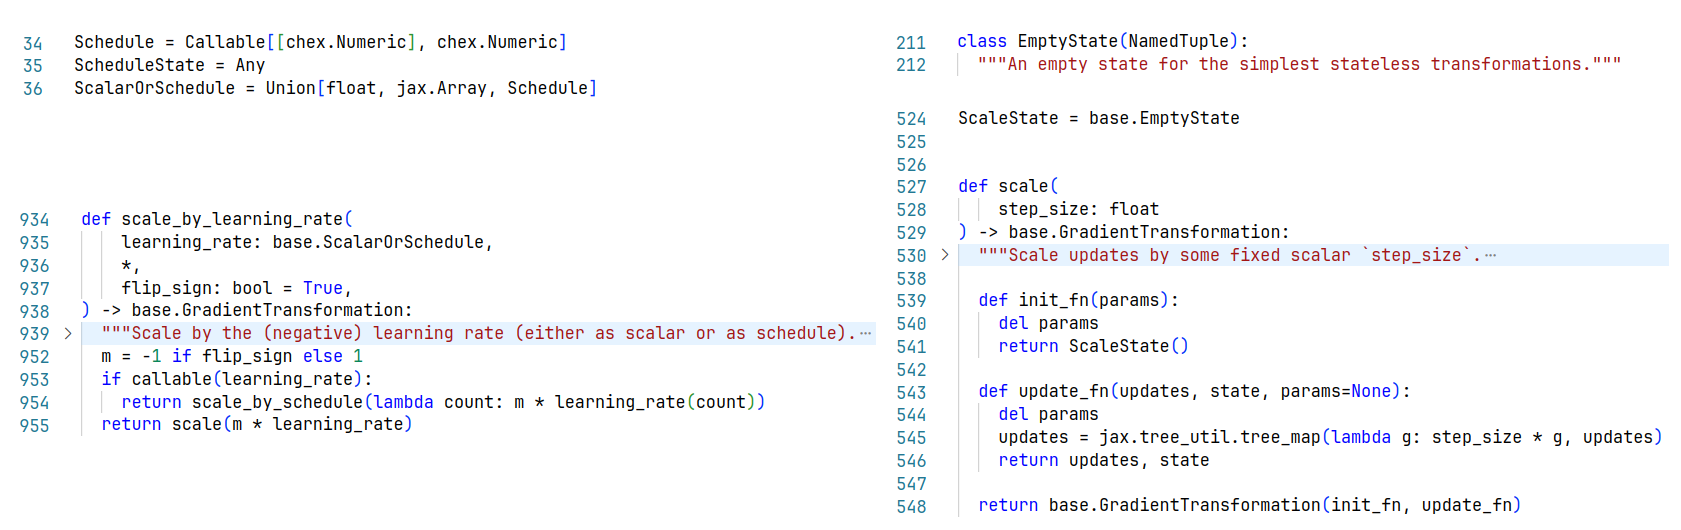

일단은 `learning_rate`에 scalar 값을 넣었다고 가정하자 (뒤에서 schedule)에 대해 다룬다. 지금은 전체적 흐름을 보기 위함이다. 

```python
  return combine.chain(
      transform.scale_by_adam(
          b1=b1,
          b2=b2,
          eps=eps,
          eps_root=eps_root,
          mu_dtype=mu_dtype,
          nesterov=nesterov,
      ),
      transform.scale_by_learning_rate(learning_rate),
  )
```

우리는 위 코드를 알아보기 위해 `transform.scale_by_adam`, `transform.scale_by_learning_rate` 함수를 탐색했다.

이것들은 다음과 같은 구조를 가진다. 예를 들어 `scale_by_adam`, `scale_by_learning_rate` 같은 함수 이름을 `FUN` 이라고 한다면

사용하지 않는 파라미터의 경우 함수 시작하자마자 `del`로 지워버린다.

---

```python

class FUNState(NamedTuple):
  count: chex.Array
  state1: ...
  state2: ...

def FUN(parameters to calculate FUN):
  def init_fn(params):
    return FUNState(...)
  
  def update_fn(update, state, params=None):
    return updates, FUNState(...)
  
  return base.GradientTransformation(init_fn, update_fn)

```

---


`return`을 다시 보면 아래와 같을 것이다.

---

```python
return combine.chain(base.GradientTransformation(init_fn, update_fn), 
                      base.GradientTransformation(init_fn, update_fn))
```

---


### `base`

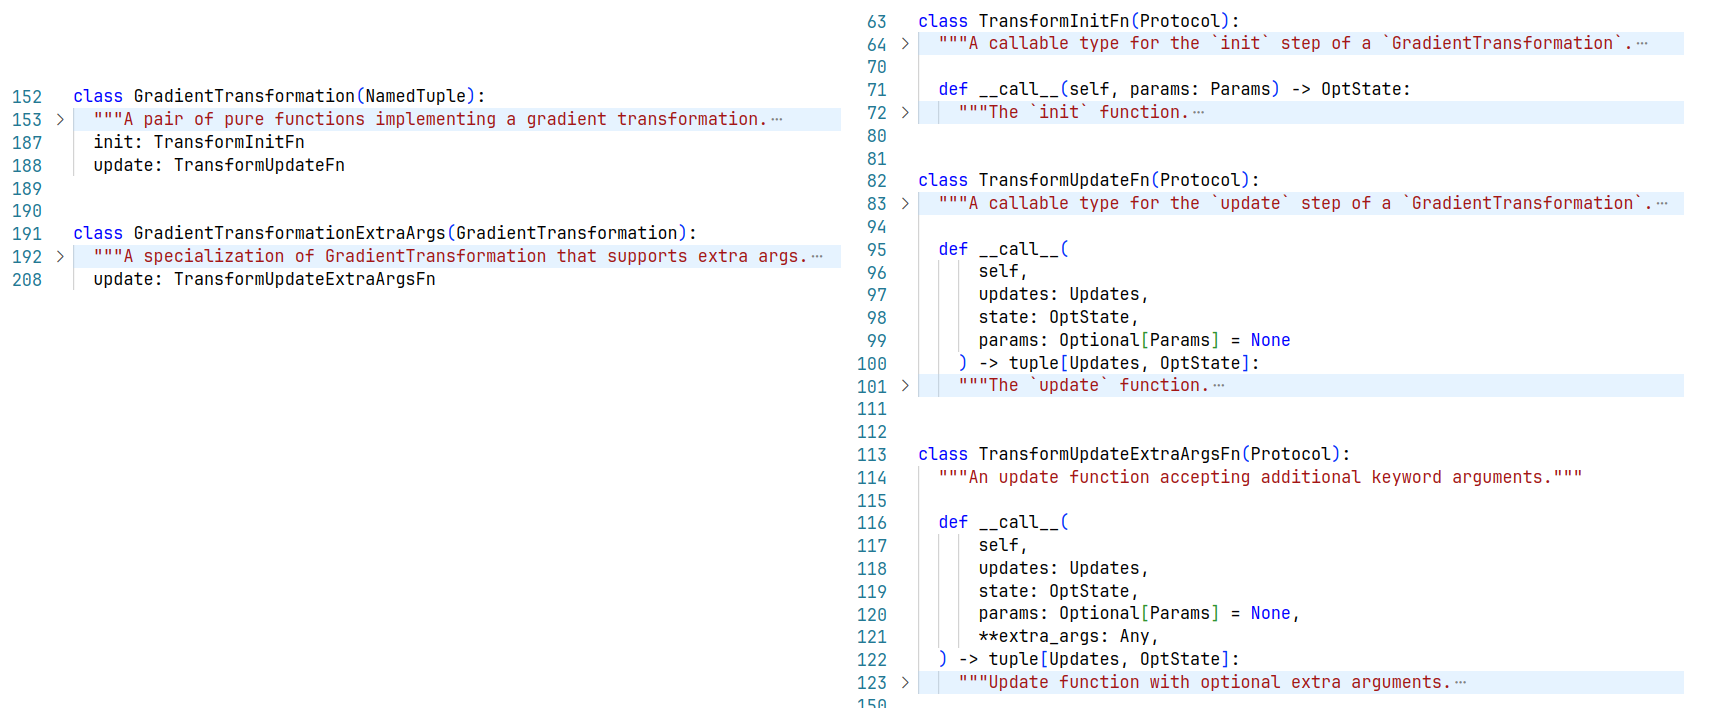

`base.GradientTransformation` 은 `NameTuple` 이기에 `init_fn`과 `update_fn`이 각각 `init`, `update`로 들어갈 것이다.

그러면 `NamedTuple`의 `init`/`update`라는 인수명으로 접근시 `init_fn`/`update_fn` 의 **함수**가 호출될 것이다.

그래서 `tx = optax.adam(learning_rate)` 와 같이 호출하고 `init`을 호출하는 것일까? 아직 아니다. 우리가 `optax.adam()`을 통해 리턴받는 것은 `base.GradientTransformation`이 아니라 `combine.chain(...)` 이다.

이제 `combine.chain(...)`을 살펴보자

### `combine.py` > `chain`

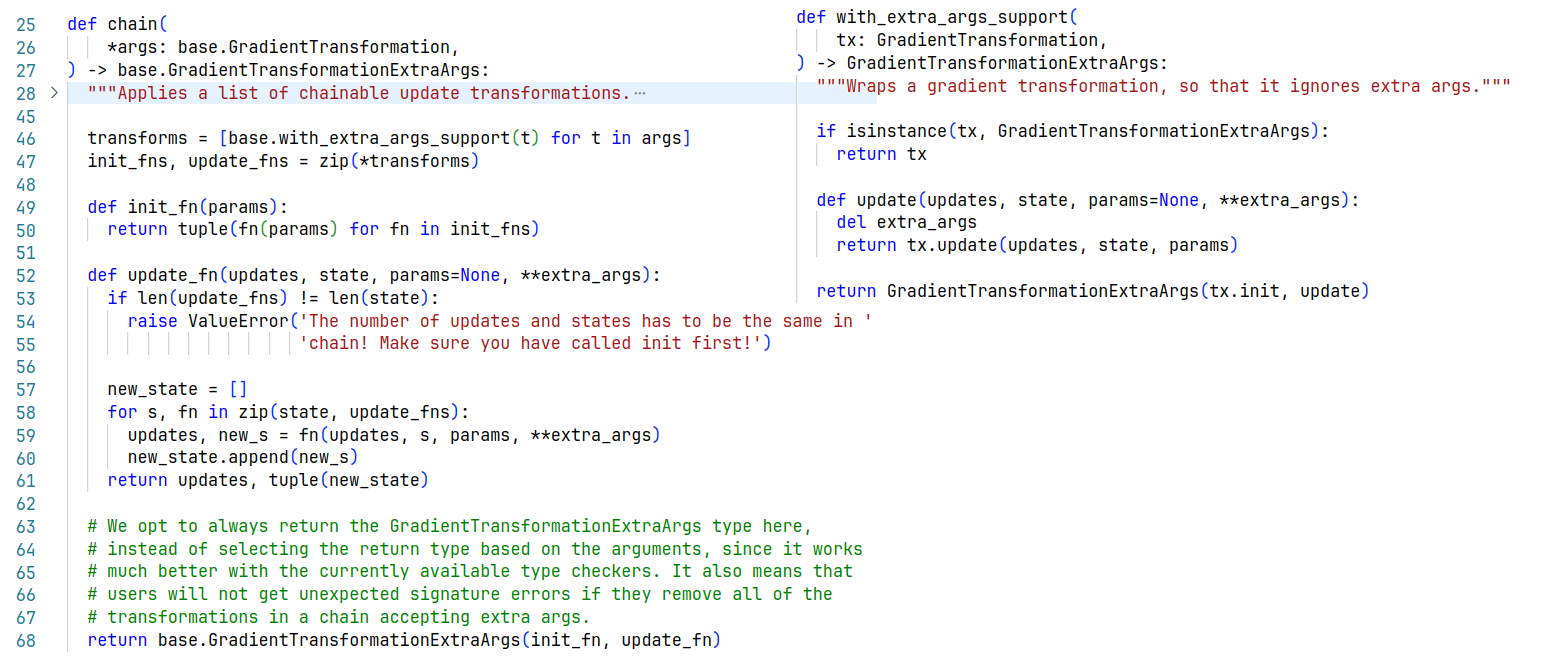

`chain` 함수는 위에서 살펴본 `transform.scale_by_adam`, `transform.scale_by_learning_rate` 와 비슷해보인다.

차근차근 살펴보면

* `with_extra_args_support`
  * `tansforms` 리스트에 해당 `transform`들을 변경하고 넣는다. 이유는 위에 초록색 주석에 써있다. 어떤 것은 추가 인자가 있고 어떤 것은 없을 경우 처리가 불편하길래 형식을 통일한다.
* 어떻게 지속적으로 인자로 주어지지 않는 `init_fns`, `update_fns`를 참조할까? -> closure of python
* `init_fn`, `update_fn` 은 상위 `chain`의 네임스페이스의 요소들을 참조하고 가공 후에 반환한다. 그렇기에 이 반환된 `init_fn`과 `update_fn`은 해당 요소들을 반환하는 함수로 계속 남아있게 된다. 실제 리터럴 값들이 아닌 함수라 `jit` 해도 상관없다.
* `update`의 경우 이제 우리가 각 chaining된 `GradientTransformation`(transform이라고 칭함) 연산들에 대해 두가지 종류의 연산을 해야 한다. 첫째는 `update`, 즉 얼마나 업데이트 해야 할지이고 두 번째는 각 transform의 state이다.
  * 그렇기에 `updates`는 transform들에 대해 하나만 존재하고 `jax.lax.scan`에 익숙하다면 `carry`라고 생각해도 좋다.
  * `state`는 각 transform에 대해 존재하게 된다.
  * 그러면 왜 마지막 transform의 이름이 `scale_by_learning_rate` 인지 이해가 될 것이다.

상속 관계도 : 오른쪽이 왼쪽을 상속한다.

`NamedTuple` -> `GradientTransformation` -> `GradientTransformationExtraArgs` 

따라서 `base.GradientTransformationExtraArgs` 는
* `init` : `TransformInitFn`
* `update` : `TransformUpdateExtraArgsFn` (`TransformUpdateFn`을 오버라이딩함)

의 요소를 가진 `NamedTuple`이 된다.

지금까지의 결과를 정리하자

```python
def adam(...) -> base.GradientTransformation:
  return combine.chain(
      transform.scale_by_adam(...),
      transform.scale_by_learning_rate(...),
  )
```

로 시작해서 `chain`의 인자로들어간 `scale_by_adam`, `scale_by_learning_rate`는 `base.GradientTransformation` 를 반환했고 이것은 `combine.chain` 함수 안에서 인자로 들어간 함수들의 `init`, `update` 결과를 종합하여 반환하는 `init`, `update`를 가진 `GradientTransformationExtraArgs`를 반환한다.

즉 `combine.chain`에서 리턴된 것은 `init`, `update`를 실행시 chaining된 함수들의 모든 결과를 적용하고 반환한다.

In [41]:
learning_rate = 0.0003
tx = optax.adam(learning_rate)

params = jnp.array([1., 3.])
x = jnp.array([3.])
y = jnp.array([9.])

def loss_fn(params, x, y):
    pred = params[0] * x + params[1]
    loss = optax.losses.l2_loss(pred, y)
    return loss.mean()

opt_state = tx.init(params)

for i in range(3):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    updates, opt_state = tx.update(grads, opt_state, params)
    print(f"params  | {params}")
    print(f"updates | {updates}")
    params = optax.apply_updates(params, updates)

params  | [1. 3.]
updates | [0.00030001 0.00030001]
params  | [1.0003 3.0003]
updates | [0.0003 0.0003]
params  | [1.0006001 3.0005999]
updates | [0.00029999 0.00029999]


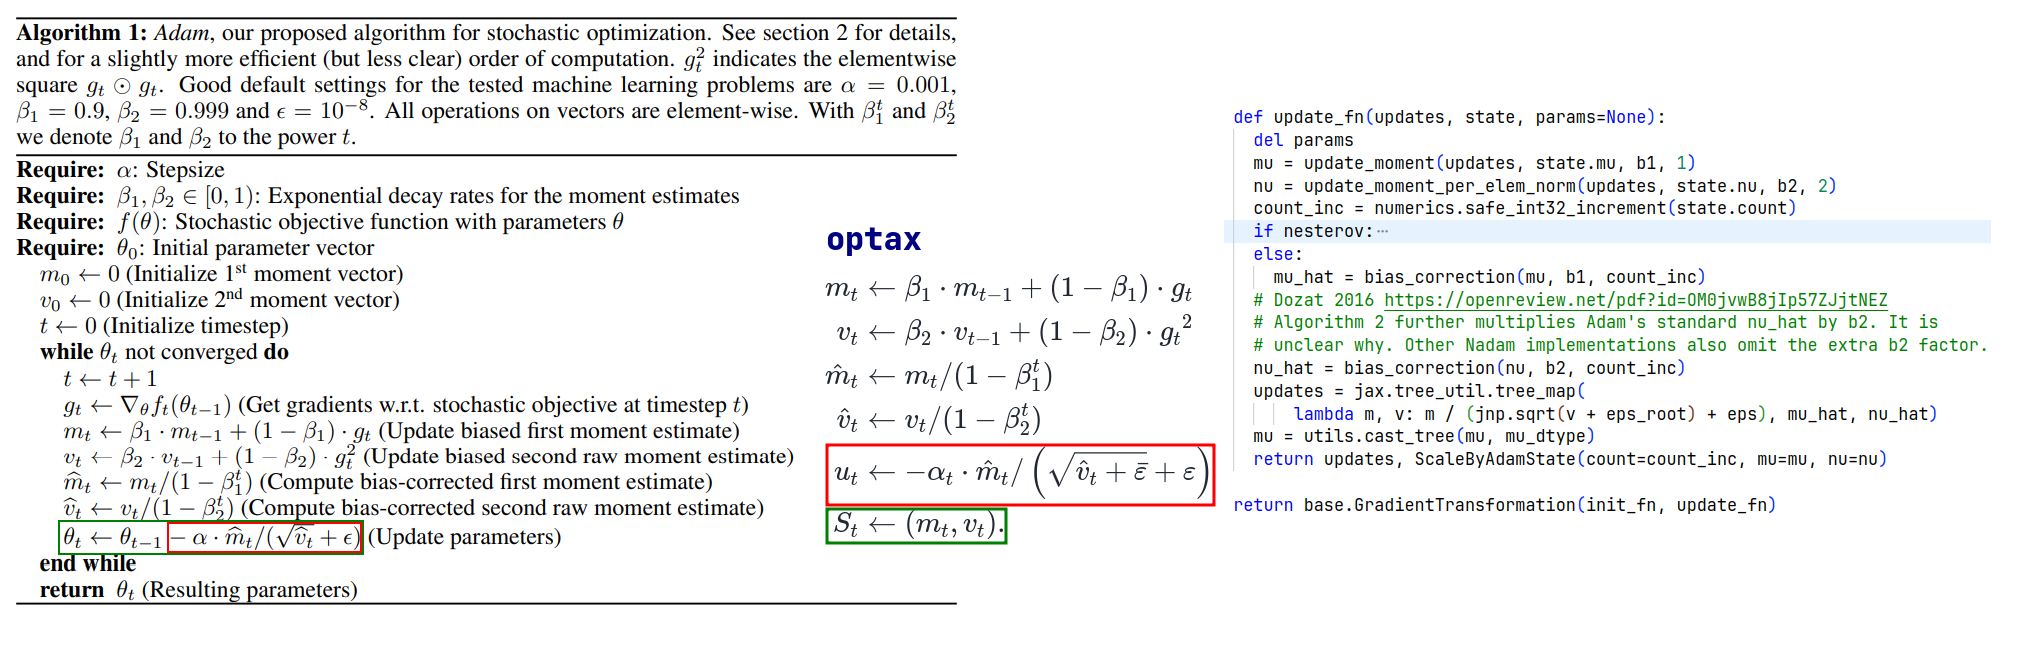

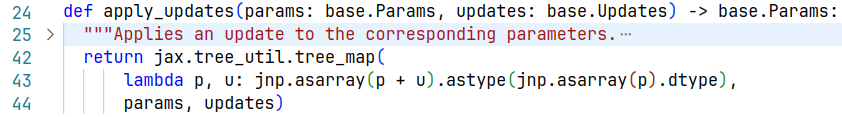

### learning_rate scheduling

모든 optimizer에 포함되어 있던 `scale_by_learning_rate` 함수를 다시 보자

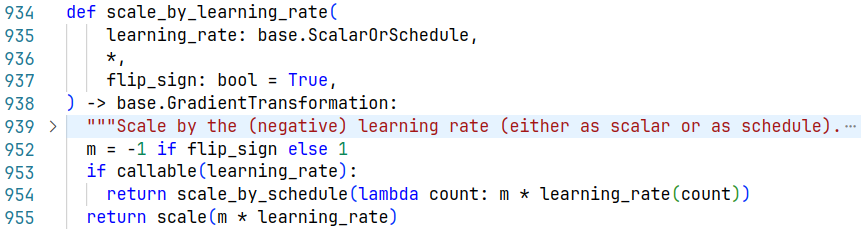

이전 사례에서는 learning_rate가 `callable` 하지 않고 scalar 값이었기 때문에 `scale` 함수를 호출하였다

그렇다면 `learning_rate`가 `callable`이면 어떨까? `scale_by_schedule`이 호출될 것이다.

지금까지 이해가 되었다면 결국 `combine.chaining`의 인수로 포함된 `scale_by_learning_rate`이 호출하는 `scale_by_schedule`은 결국 

`base.GradientTransformation`의 형태로 `init`, `update`을 요소로 갖는 `NamedTuple`이라는 것을 알 것이다. 그럼 해당 함수를 보자

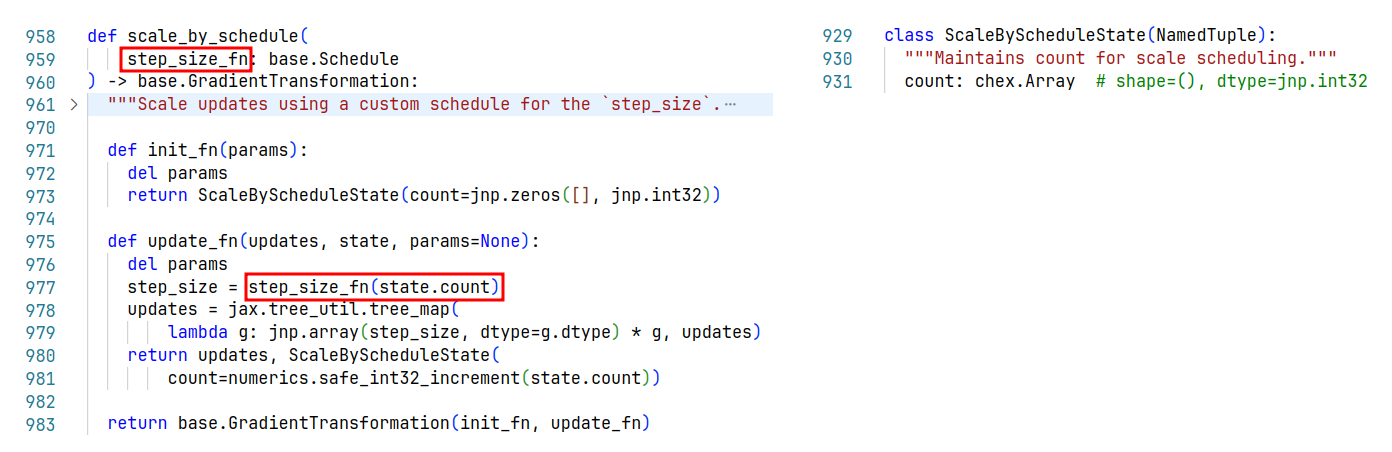

우리의 예상과 들어맞았다. 당연하지만 이전과 똑같은 형태를 리턴한다.

 `schedule_by_learning_rate` 를 함수로 주게 된다면 `state.count`를 해당 함수에 적용한 결과를 `step_size` (learning_rate)로 저장후 `update` 에 곱한 결과를 반환할 것이다. 클로저 형태로 `update_fn` 은 `step_size_fn`을 참조하게 될 것이고 인수로 받은 `state`의 `count`를 이용하여 연산하여 `step_size`를 구한다.

In [ ]:
schedule = optax.linear_schedule(init_value=1.0, end_value=0.2, transition_steps=300, transitions_begin=)